# Problem Definition

Analyzing time to death (churn) of a customer in a telecom company using the Survival Analysis.

In this lab, we will apply learned concepts about survival analysis lecture to analyze customer churn for a telecom company.

Customer Churn is a well-studied problem in ML, which mainly aims to predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The given Customer-Churn.csv dataset contains 7k+ customer data points. The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

This lab contains three parts. In step 1, you will need to perform basic data exploration and data cleaning. In step 2, you will need to draw Kaplan-Meier for overall data and different user groups. In the last step 3, you will need to apply Cox Proportional Hazards model on the dataset to learn the important features for explaining customer churn.

## setting up the environment

In [1]:
!pip install lifelines

In [2]:
# import potential libraries for data analysis
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
# allow display of multiple outputs by running one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Data

Step 1: Data Type Exploration

First, answer the following three questions using code and results.
1) How many data entries/objects?
2) What are the attribute types?
3) Are there any missing values?

In [3]:
# put your code for implementing Step 1 in this code block
# you many need pd.read_csv, pd.head(), pd.info(), pd.describe(), msno.bar()


In [4]:
df = pd.read_csv('Customer-Churn.csv')

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,2,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,4,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,5,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   int64  
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We have `7043` entries 🧐

In [7]:
print("Numerical columns:", df.select_dtypes(include=['int64', 'float64']).columns.tolist())

print("Categorical columns:", df.select_dtypes(include=['object']).columns.tolist())


Numerical columns: ['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


We have Numerical and Categorical features as shown in the lists 🧩👩🏻‍💻

<Axes: >

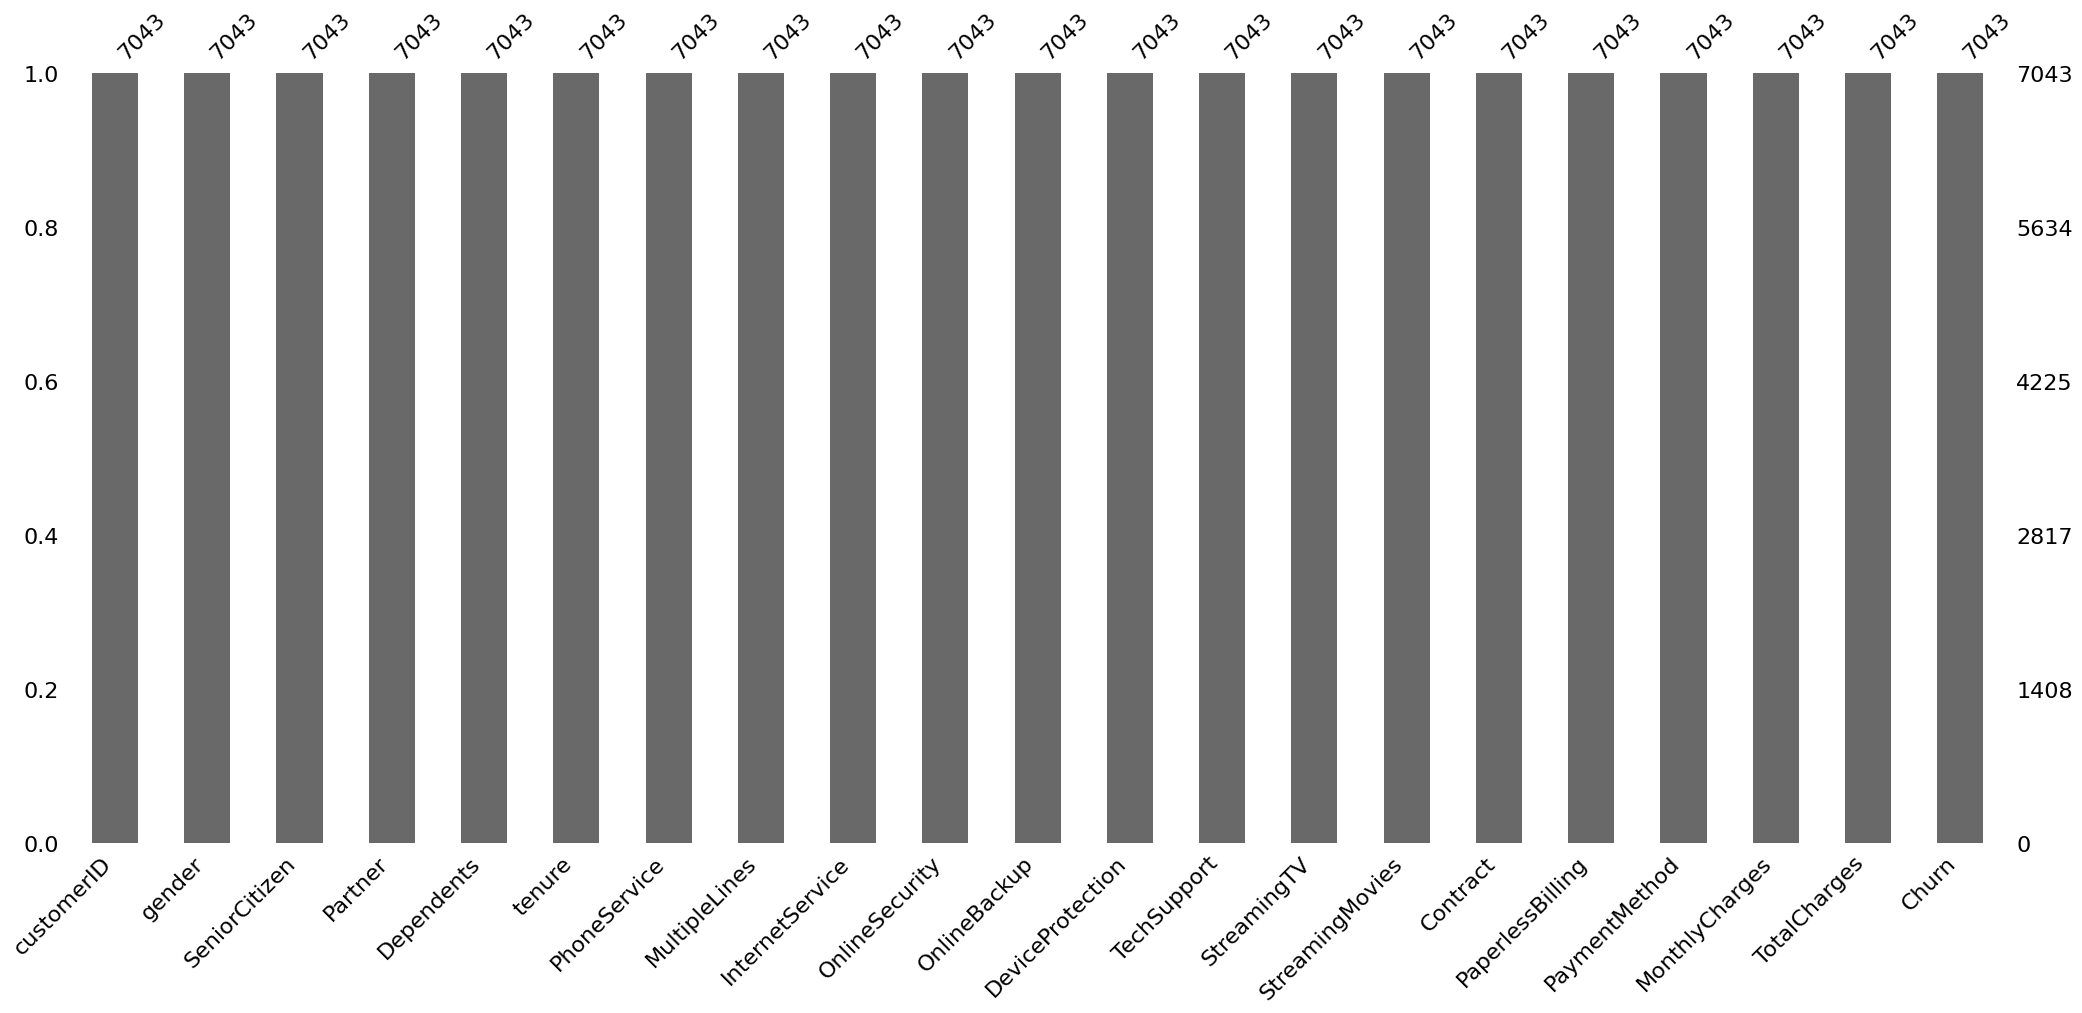

In [8]:
msno.bar(df)

We don't have missing values 🎉

In [9]:
len(df['customerID'].unique())

7043

# More Exploration

In [10]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

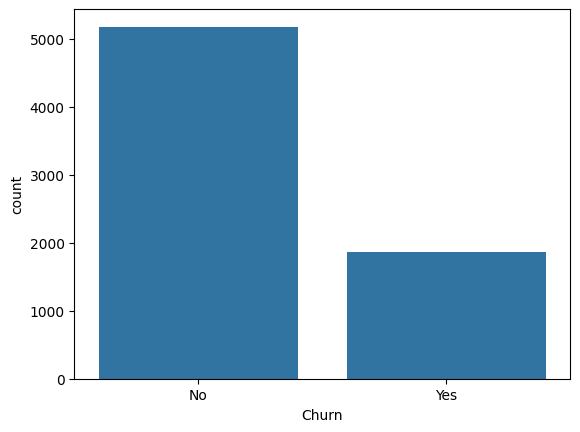

In [11]:

sns.countplot(x='Churn', data=df)
plt.show()


<Axes: xlabel='PaymentMethod'>

Text(0.5, 1.0, 'Churn Rate by Payment Method')

Text(0.5, 0, 'Payment Method')

Text(0, 0.5, 'Number of Customers')

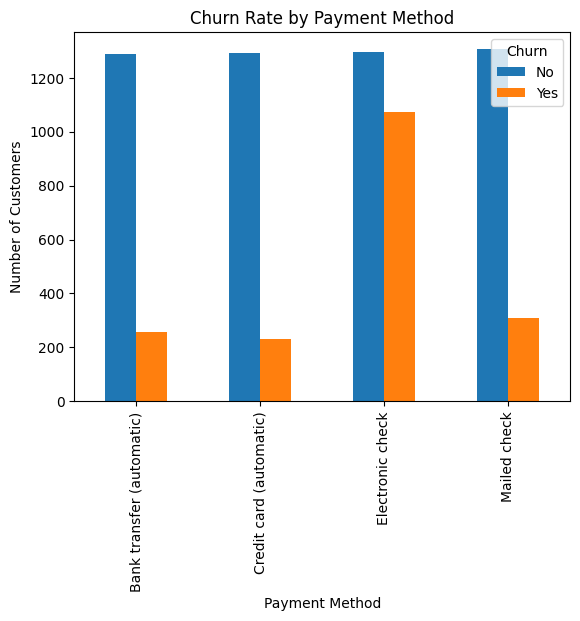

In [12]:
df.groupby('PaymentMethod')['Churn'].value_counts().unstack().plot(kind='bar')

plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')

plt.show()


<Axes: xlabel='Contract'>

Text(0.5, 1.0, 'Churn Rate by Contract')

Text(0.5, 0, 'Contract')

Text(0, 0.5, 'Number of Customers')

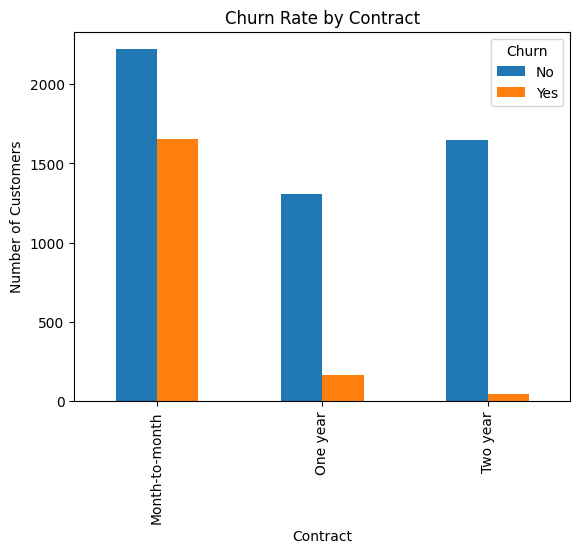

In [13]:
df.groupby('Contract')['Churn'].value_counts().unstack().plot(kind='bar')

plt.title('Churn Rate by Contract')
plt.xlabel('Contract')
plt.ylabel('Number of Customers')

plt.show()


Step 2: Plot KaplanMeier curve to describe churn data, note you need to transfer attribute "tenure" to float and Churn to bool attribute.

1) first plot the KM curve for all users.
2) secondly, plot the KM curve for users grouped by their Payment Method
3) thirdly, plot the KM curve for users grouped by their Contract method

In [14]:
# transform tenure and churn features



# fitting kmf to all churn data, you may use the KaplanMeierFitter() from lifelines


# plotting kmf curve


In [15]:
# creating Kaplan-Meier curve plots segmented by categorical variables, i.e., PaymentMethod, Contract.


In [16]:
df[['tenure','Churn']]

,tenure,Churn
0,1,No
1,34,No
2,2,Yes
3,45,No
4,2,Yes
...,...,...
7038,24,No
7039,72,No
7040,11,No
7041,4,Yes


In [17]:
# transform tenure and churn features

df['Churn'] = df['Churn'].apply(lambda x: True if x == 'Yes' else False)
df['tenure'] = df['tenure'].astype(float)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

<Axes: xlabel='timeline'>

Text(0.5, 1.0, 'Survival Curve for Customers')

Text(0.5, 0, 'Age (months)')

Text(0, 0.5, 'Survival Probability')

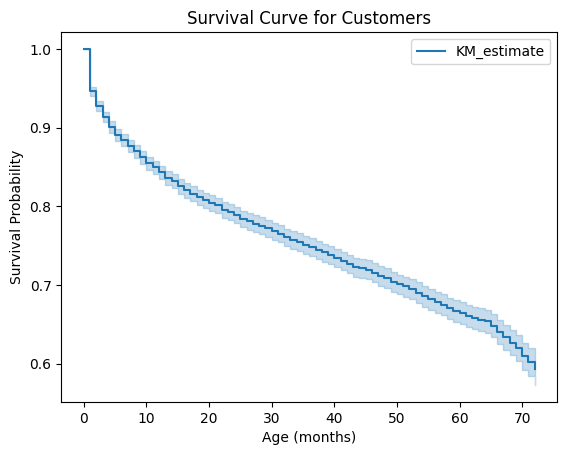

Median survival time: inf


In [36]:
# fitting kmf to all churn data, you may use the KaplanMeierFitter() from lifelines


kmf = KaplanMeierFitter()

kmf.fit(df['tenure'], event_observed=df['Churn'])

kmf.plot()
plt.title('Survival Curve for Customers')
plt.xlabel('Age (months)')
plt.ylabel('Survival Probability')
plt.show()

80% of the sample, survive more than 20 months.

<lifelines.KaplanMeierFitter:"Electronic check", fitted with 2365 total observations, 1294 right-censored observations>

<Axes: xlabel='timeline'>

<lifelines.KaplanMeierFitter:"Mailed check", fitted with 1612 total observations, 1304 right-censored observations>

<Axes: xlabel='timeline'>

<lifelines.KaplanMeierFitter:"Bank transfer (automatic)", fitted with 1544 total observations, 1286 right-censored observations>

<Axes: xlabel='timeline'>

<lifelines.KaplanMeierFitter:"Credit card (automatic)", fitted with 1522 total observations, 1290 right-censored observations>

<Axes: xlabel='timeline'>

Text(0.5, 1.0, 'Kaplan-Meier Curve by Payment Method')

Text(0.5, 0, 'Tenure')

Text(0, 0.5, 'Survival Probability')

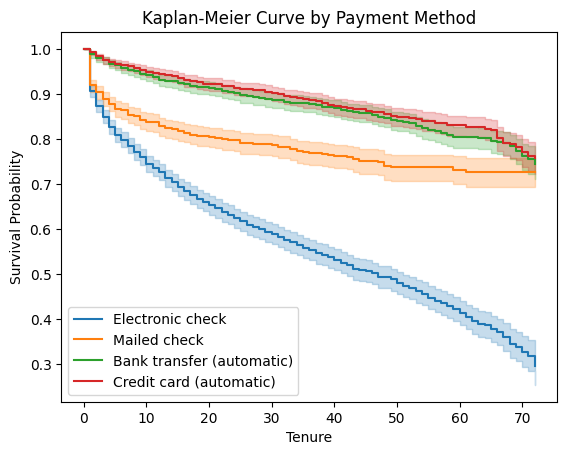

In [19]:
for method in df['PaymentMethod'].unique():
    mask = df['PaymentMethod'] == method
    kmf.fit(df[mask]['tenure'], event_observed=df[mask]['Churn'], label=method)
    kmf.plot()
plt.title('Kaplan-Meier Curve by Payment Method')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

<lifelines.KaplanMeierFitter:"Month-to-month", fitted with 3875 total observations, 2220 right-censored observations>

<Axes: xlabel='timeline'>

<lifelines.KaplanMeierFitter:"One year", fitted with 1473 total observations, 1307 right-censored observations>

<Axes: xlabel='timeline'>

<lifelines.KaplanMeierFitter:"Two year", fitted with 1695 total observations, 1647 right-censored observations>

<Axes: xlabel='timeline'>

Text(0.5, 1.0, 'Kaplan-Meier Curve by Contract')

Text(0.5, 0, 'Tenure')

Text(0, 0.5, 'Survival Probability')

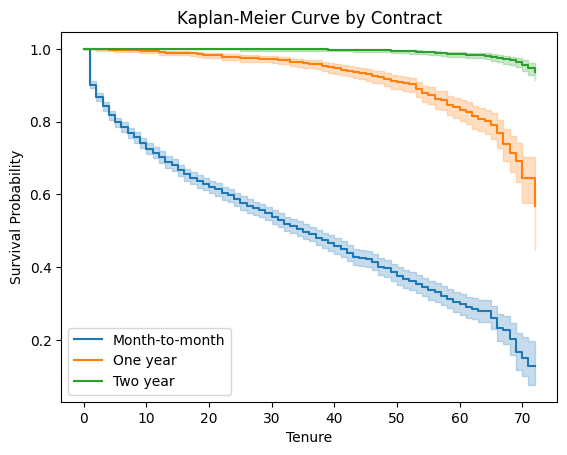

In [20]:
for contract_type in df['Contract'].unique():
    mask = df['Contract'] == contract_type
    kmf.fit(df[mask]['tenure'], event_observed=df[mask]['Churn'], label=contract_type)
    kmf.plot()
plt.title('Kaplan-Meier Curve by Contract')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Step 3: Feature engineering and build Cox Proportional Hazards using all churn data.
You may use CoxPHFitter, and print_summary from lifelines library

In [21]:
# Now, based on your above check, carefully read the attributes_des.txt file which contains the detailed description for each attribute.
# then, decide how to handle the categorical features in this dataset. Be careful about "TotalCharges".
# You may consider using pd.get_dummies(data, drop_first=True, columns=one_hot_encoded_columns) to one-hot encode some categorical features.

In [22]:
# train your Cox Proportional Hazard model using the processed data and print the summary

# Feature Engineeing

In [23]:
df[df.select_dtypes(include=['object']).columns.tolist()].head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65


In [24]:
# convert TotalCharges to float

df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [25]:
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
  df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

In [26]:

df_encoded = pd.get_dummies(df[df.select_dtypes(include=['object']).columns.tolist()], drop_first=True)
df = pd.concat([df, df_encoded], axis=1)
df.drop(df.select_dtypes(include=['object']).columns.tolist(), axis=1, inplace=True)


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

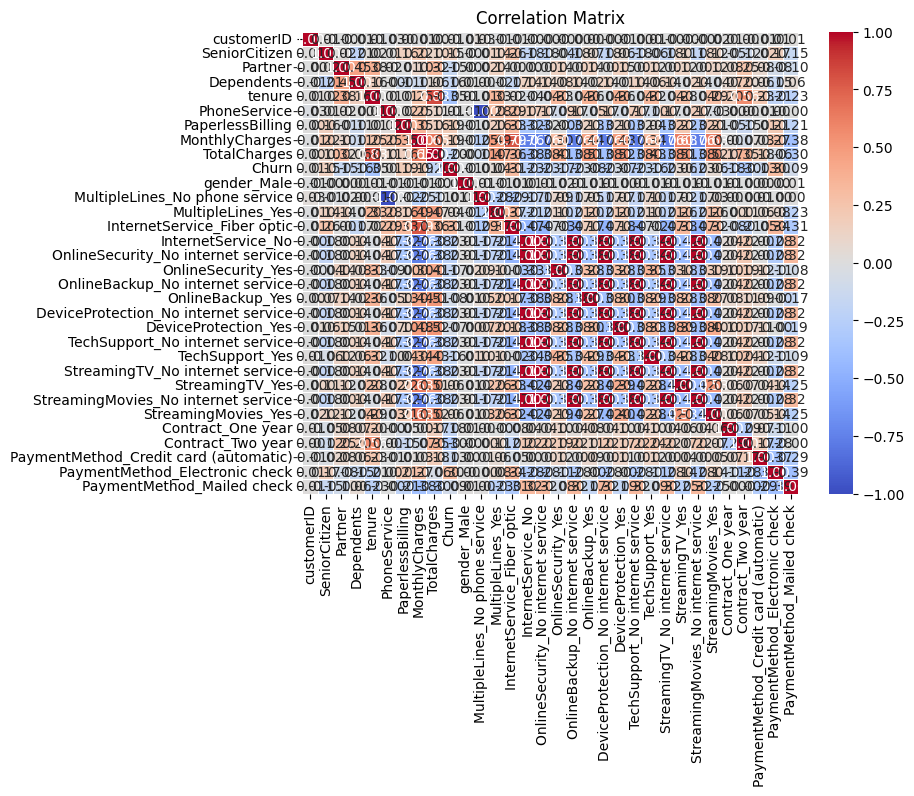

In [27]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [28]:
for col in df.select_dtypes(include=['bool']).columns.tolist():
  df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [29]:
df

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1.0,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,0,34.0,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,3,0,0,0,2.0,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,45.0,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,5,0,0,0,2.0,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,1,1,24.0,1,1,84.80,1990.50,0,...,1,0,1,0,1,1,0,0,0,1
7039,7040,0,1,1,72.0,1,1,103.20,7362.90,0,...,0,0,1,0,1,1,0,1,0,0
7040,7041,0,1,1,11.0,0,1,29.60,346.45,0,...,0,0,0,0,0,0,0,0,1,0
7041,7042,1,1,0,4.0,1,1,74.40,306.60,1,...,0,0,0,0,0,0,0,0,0,1


# Cox Proportional Hazard model  

In [30]:
vif = pd.DataFrame()
vif['features'] = df.columns
vif['vif_value'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vif.sort_values(by="vif_value", ascending=False)

,features,vif_value
21,TechSupport_No internet service,inf
19,DeviceProtection_No internet service,inf
17,OnlineBackup_No internet service,inf
23,StreamingTV_No internet service,inf
15,OnlineSecurity_No internet service,inf
14,InternetService_No,inf
25,StreamingMovies_No internet service,inf
5,PhoneService,1776.159915
7,MonthlyCharges,865.207305
13,InternetService_Fiber optic,148.362389


In [31]:
vif_df = vif.loc[vif['vif_value'] > 30]
vif_cols = vif_df['features'].tolist()
df.drop(vif_cols, axis=1, inplace=True)

In [32]:
df.drop('customerID', axis=1, inplace=True)

In [33]:
df

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,TotalCharges,Churn,gender_Male,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1.0,1,29.85,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,34.0,0,1889.50,0,1,0,1,0,1,0,0,0,1,0,0,0,1
2,0,0,0,2.0,1,108.15,1,1,0,1,1,0,0,0,0,0,0,0,0,1
3,0,0,0,45.0,0,1840.75,0,1,0,1,0,1,1,0,0,1,0,0,0,0
4,0,0,0,2.0,1,151.65,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24.0,1,1990.50,0,1,1,1,0,1,1,1,1,1,0,0,0,1
7039,0,1,1,72.0,1,7362.90,0,0,1,0,1,1,0,1,1,1,0,1,0,0
7040,0,1,1,11.0,1,346.45,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7041,1,1,0,4.0,1,306.60,1,1,1,0,0,0,0,0,0,0,0,0,0,1


In [34]:
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure', event_col='Churn')

print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13222.29
         time fit was run = 2024-06-10 19:09:32 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
Partner                                -0.25       0.78       0.05            -0.36            -0.14                 0.70                 0.87
Dependents                             -0.21       0.81       0.07            -0.35            -0.07                 0.71                 0.93
PaperlessBilling                        0.38       1.47       0.06             0.27             0.50                 1.31                 1.64
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gender_Male                            -0.02       0.98       0.05            -0.11             0.07                 0.90                 1.07
MultipleLines_Yes                       0.56       1.76       0.05             0.46             0.66                 1.59                 1.94
OnlineSecurity_Yes                     -0.11       0.89       0.07            -0.24             0.02                 0.79                 1.02
OnlineBackup_Yes                        0.01       1.01       0.06            -0.10             0.12                 0.90                 1.12
DeviceProtection_Yes                    0.21       1.24       0.06             0.10             0.32                 1.11                 1.38
TechSupport_Yes                        -0.03       0.97       0.06            -0.16             0.09                 0.85                 1.10
StreamingTV_Yes                         0.48       1.61       0.06             0.37             0.59                 1.44                 1.80
StreamingMovies_Yes                     0.46       1.58       0.06             0.35             0.57                 1.41                 1.76
Contract_One year                      -1.92       0.15       0.09            -2.10            -1.74                 0.12                 0.18
Contract_Two year                      -4.55       0.01       0.18            -4.90            -4.20                 0.01                 0.02
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.58       1.78       0.07             0.43             0.72                 1.54                 2.05
PaymentMethod_Mailed check              0.28       1.32       0.09             0.11             0.45                 1.11                 1.57

                                        cmp to      z      p   -log2(p)
covariate                                                              
SeniorCitizen                             0.00   2.58   0.01       6.64
Partner                                   0.00  -4.56 <0.005      17.57
Dependents                                0.00  -3.02 <0.005       8.64
PaperlessBilling                          0.00   6.72 <0.005      35.64
TotalCharges                              0.00 -34.18 <0.005     848.29
gender_Male                               0.00  -0.40   0.69       0.54
MultipleLines_Yes                         0.00  10.98 <0.005      90.81
OnlineSecurity_Yes                        0.00  -1.70   0.09       3.49
OnlineBackup_Yes                          0.00   0.16 

None


In [35]:
c_index = cph.concordance_index_
print("Concordance Index:", c_index)

Concordance Index: 0.9200213791976428


From the summmary we can conclude that:

- biggest coef is 4.55	for	`Contract_Two year`	with negative sign meaning that a Contract with Two year it decrease the hazard.

- P-Value < 0.005 indicates a strong level of significance. It means that the observed association between the predictor variable and the hazard rate is highly unlikely to be due to chance and that can be noticed by `Dependents`, `PaperlessBilling`, `TotalCharges`, `MultipleLines_Yes`, `DeviceProtection_Yes`, `StreamingTV_Yes`, `StreamingMovies_Yes`, `Contract_One year`,	`Contract_Two year`,	`PaymentMethod_Electronic check`,	and`PaymentMethod_Mailed check`.